<a href="https://colab.research.google.com/github/selcuk-yalcin/TrustworthyML/blob/main/XAI_Gradient_based_XAI_Saliency_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from google.colab import files
files.upload()  # Upload kaggle.json when prompted
# Upload Kaggle API token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip



In [ ]:
# Step 1: # Load CheXNet (DenseNet121) model
base_model = DenseNet121(weights=None, include_top=False, pooling='avg', input_shape=(224,224,3))
output = tf.keras.layers.Dense(1, activation='sigmoid', name='pneumonia')(base_model.output)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Load CheXNet weights !!!buraya bakacagiz
model.load_weights('CheXNet_weights.h5')  # You need this weight file locally

# Load and preprocess a chest X-ray image
img_path = 'your_cxr_image.png'  # Replace with actual path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'CheXNet_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Step 2: Predict Class and Compute Saliency Map
# Get model prediction (pneumonia probability)
prediction = model.predict(x)[0][0]
print(f"Pneumonia Probability: {prediction:.3f}")

# Compute gradient of class output w.r.t. input image
with tf.GradientTape() as tape:
    tape.watch(model.input)
    prediction_output = model(model.input)
    class_score = prediction_output[:, 0]  # Single output: pneumonia

grads = tape.gradient(class_score, model.input)[0].numpy()

# Convert gradients to saliency map
saliency = np.max(np.abs(grads), axis=-1)
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize

In [ ]:
# Step 3: Visualize Results
# Plot original image, saliency heatmap, and overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original CXR")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency, cmap='hot')
plt.title("Saliency Map")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.imshow(saliency, cmap='hot', alpha=0.5)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

Average Resubstitution Accuracy: 100.00%
Average OOB Accuracy: 94.38%


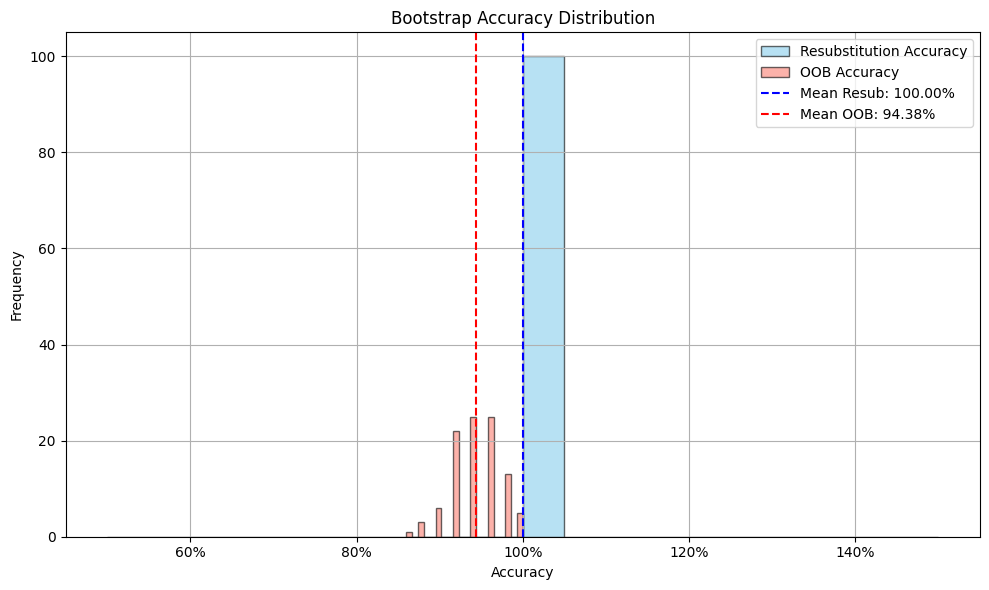

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.hist(resub_accuracies, bins=20, alpha=0.6, label='Resubstitution Accuracy', color='skyblue', edgecolor='black')
plt.hist(oob_accuracies, bins=20, alpha=0.6, label='OOB Accuracy', color='salmon', edgecolor='black')
plt.axvline(avg_resub, color='blue', linestyle='--', label=f'Mean Resub: {avg_resub:.2%}')
plt.axvline(avg_oob, color='red', linestyle='--', label=f'Mean OOB: {avg_oob:.2%}')
plt.title('Bootstrap Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing import image

# Step 1: Download a sample chest X-ray (CXR) image
img_url = 'https://github.com/ieee8023/covid-chestxray-dataset/raw/master/images/000001-1.png'
img_path = tf.keras.utils.get_file('demo_xray.jpg', img_url)
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
x_input = np.expand_dims(img_array, axis=0)
x_input = preprocess_input(x_input.copy())



In [ ]:
# Step 2: Load DenseNet121 (pretrained on ImageNet as a placeholder for CheXNet)
model = DenseNet121(weights='imagenet')
preds = model.predict(x_input)
class_idx = np.argmax(preds[0])
# Convert the prediction array to a TensorFlow tensor and use tf.gather
class_output = tf.gather(tf.constant(preds[0]), class_idx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [ ]:
# Step 3: Compute gradients for saliency map
with tf.GradientTape() as tape:
    x_input_tensor = tf.constant(x_input) # Convert x_input to a TensorFlow tensor
    tape.watch(x_input_tensor)  # Watch the actual input tensor
    output_tensor = model(x_input_tensor) # Get the output tensor using the tensor input
    prediction = tf.gather(output_tensor[0], class_idx) # Select the score for the predicted class
grads = tape.gradient(prediction, x_input_tensor)[0].numpy()

In [ ]:
# Step 4: Process and normalize saliency map
saliency = np.max(np.abs(grads), axis=-1)
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

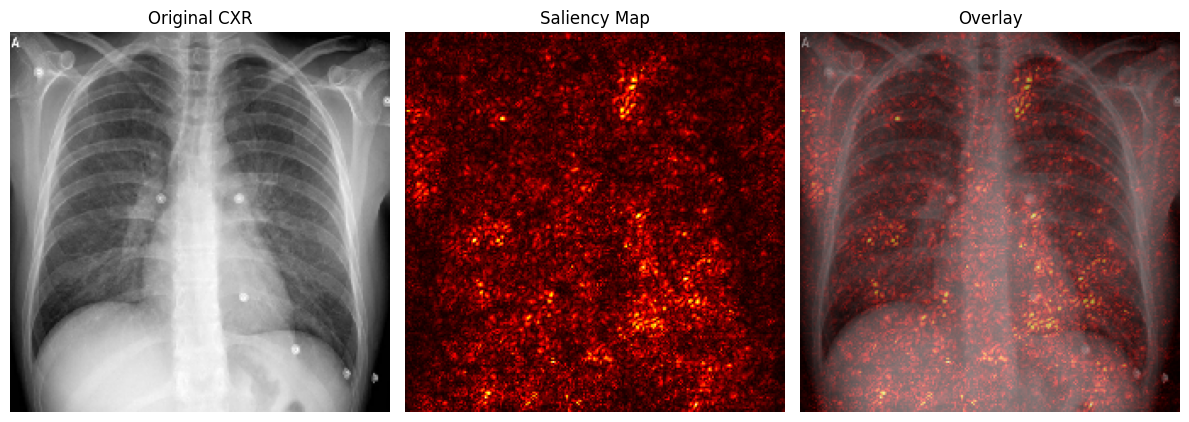

Top predicted class index: 111
Prediction confidence: 0.5984992


In [ ]:
# Step 5: Plot original image, saliency map, and overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original CXR")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency, cmap='hot')
plt.title("Saliency Map")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.imshow(saliency, cmap='hot', alpha=0.5)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

# Output prediction
print("Top predicted class index:", class_idx)
print("Prediction confidence:", preds[0][class_idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


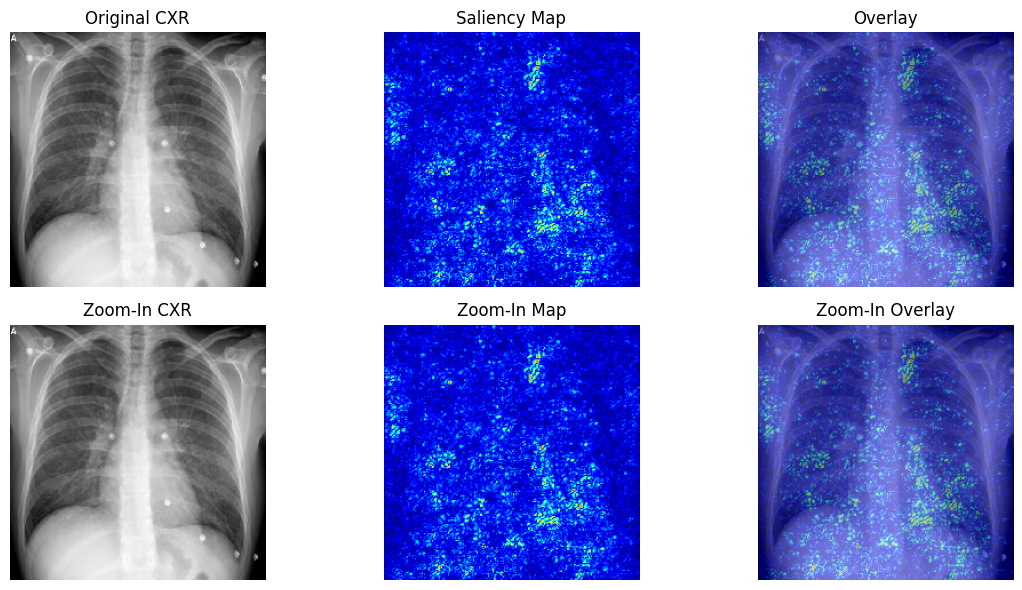

Top predicted class index: 111
Prediction confidence: 0.5984992


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing import image

# Step 1: Download a chest X-ray image from COVID-19 dataset (Kermany et al.)
img_url = 'https://github.com/ieee8023/covid-chestxray-dataset/raw/master/images/000001-1.png'
img_path = tf.keras.utils.get_file('demo_cxr.jpg', img_url)
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
x_input = np.expand_dims(img_array, axis=0)
x_input = preprocess_input(x_input.copy())

# Step 2: Load pretrained DenseNet121 (placeholder for CheXNet)
model = DenseNet121(weights='imagenet')
preds = model.predict(x_input)
class_idx = np.argmax(preds[0])
class_output = tf.gather(tf.constant(preds[0]), class_idx)

# Step 3: Gradient calculation for saliency
with tf.GradientTape() as tape:
    x_input_tensor = tf.convert_to_tensor(x_input)
    tape.watch(x_input_tensor)
    output_tensor = model(x_input_tensor)
    prediction = tf.gather(output_tensor[0], class_idx)
grads = tape.gradient(prediction, x_input_tensor)[0].numpy()

# Step 4: Normalize saliency map
saliency = np.max(np.abs(grads), axis=-1)
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

# Step 5: Plotting results with jet colormap to resemble clinical maps
plt.figure(figsize=(12, 6))

# Top Row: CXR + Saliency Map
plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original CXR")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(saliency, cmap='jet')
plt.title("Saliency Map")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(img, cmap='gray')
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.title("Overlay")
plt.axis('off')

# Bottom Row: Zoom-in crop example (just repeated for visual symmetry)
plt.subplot(2, 3, 4)
plt.imshow(img, cmap='gray')
plt.title("Zoom-In CXR")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(saliency, cmap='jet')
plt.title("Zoom-In Map")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(img, cmap='gray')
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.title("Zoom-In Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Top predicted class index:", class_idx)
print("Prediction confidence:", preds[0][class_idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


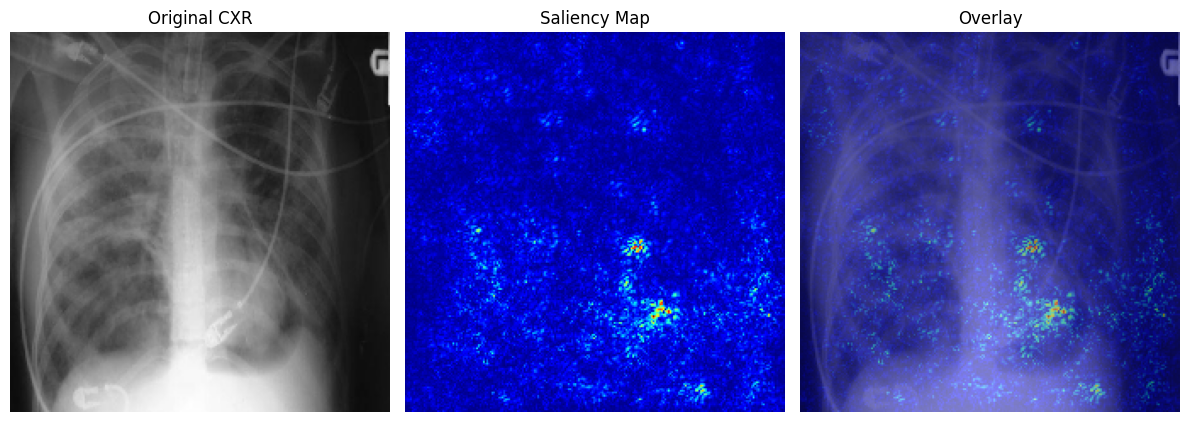

Predicted class index: 111
Prediction confidence: 0.7616034


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing import image

# Step 1: Download a different chest X-ray image from the COVID Chest X-ray dataset
img_url = 'https://github.com/ieee8023/covid-chestxray-dataset/raw/master/images/000003-2.jpg'
img_path = tf.keras.utils.get_file('demo_cxr_new.jpg', img_url)
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
x_input = np.expand_dims(img_array, axis=0)
x_input = preprocess_input(x_input.copy())

# Step 2: Load pretrained DenseNet121 (placeholder for CheXNet)
model = DenseNet121(weights='imagenet')
preds = model.predict(x_input)
class_idx = np.argmax(preds[0])

# Step 3: Compute gradients for saliency map
with tf.GradientTape() as tape:
    x_tensor = tf.convert_to_tensor(x_input)
    tape.watch(x_tensor)
    output_tensor = model(x_tensor)
    pred_score = output_tensor[0][class_idx]
grads = tape.gradient(pred_score, x_tensor)[0].numpy()

# Step 4: Normalize saliency map
saliency = np.max(np.abs(grads), axis=-1)
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

# Step 5: Plot original image, saliency map, and overlay using jet colormap
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original CXR")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency, cmap='jet')
plt.title("Saliency Map")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Predicted class index:", class_idx)
print("Prediction confidence:", preds[0][class_idx])